In [2]:
#!/usr/bin/env python
# coding: utf-8

# # Fixed Relative Accuracy Analysis - Handles Format Mismatch
# 
# This version correctly handles the format differences between extractions and ground truth

import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set paths
EXTRACTION_PATH = Path(r"E:\langchain\Dissertation\data\extractions")
GROUND_TRUTH_PATH = Path(r"E:\langchain\Dissertation\data\ground_truth")
RESULTS_PATH = Path(r"E:\langchain\Dissertation\results")
RESULTS_PATH.mkdir(exist_ok=True)

print("GPT-4V Chart Extraction Relative Accuracy Analysis (FIXED)")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

GPT-4V Chart Extraction Relative Accuracy Analysis (FIXED)
Analysis Date: 2025-07-30 15:54:57


#### SECTION 1. Load Data Functions

In [3]:
def load_extraction_results():
    """Load all extraction results from JSON files"""
    extractions = {}
    json_files = list(EXTRACTION_PATH.glob("*.json"))
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                extractions[json_file.stem] = data
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    print(f"\nLoaded {len(extractions)} extraction results")
    return extractions

def load_ground_truth():
    """Load ground truth data from chart_configurations.json"""
    ground_truth = {}
    
    config_file = GROUND_TRUTH_PATH / "chart_configurations.json"
    if config_file.exists():
        with open(config_file, 'r') as f:
            configs = json.load(f)
            for config in configs:
                ground_truth[config['id']] = config
        print(f"Loaded {len(ground_truth)} ground truth entries")
    else:
        print("WARNING: chart_configurations.json not found!")
    
    return ground_truth

# Load data
extractions = load_extraction_results()
ground_truth = load_ground_truth()


Loaded 1399 extraction results
Loaded 200 ground truth entries


#### 2. Metric Calculation Functions

In [10]:
def normalize_extraction_data(extracted_data):
    """Normalize extraction data to standard format"""
    normalized = []
    
    if isinstance(extracted_data, list):
        for item in extracted_data:
            if isinstance(item, dict) and 'category' in item and 'value' in item:
                # Split combined category-series format
                category = item['category']
                value = float(item['value']) if item['value'] is not None else 0.0
                normalized.append({'category': category, 'value': value})
    
    elif isinstance(extracted_data, dict):
        for key, value in extracted_data.items():
            normalized.append({'category': key, 'value': float(value) if value is not None else 0.0})
    
    return normalized

def normalize_extraction_data(extracted_data):
    """Normalize extraction data to standard format"""
    normalized = []

    if isinstance(extracted_data, list):
        for item in extracted_data:
            if isinstance(item, dict) and 'category' in item and 'value' in item:
                category = item['category']
                raw_value = item['value']
                
                try:
                    # Attempt to cast to float if possible
                    value = float(raw_value) if isinstance(raw_value, (int, float, str)) else 0.0
                except (ValueError, TypeError):
                    value = 0.0
                
                normalized.append({'category': category, 'value': value})

    elif isinstance(extracted_data, dict):
        for key, value in extracted_data.items():
            try:
                normalized.append({
                    'category': key,
                    'value': float(value) if isinstance(value, (int, float, str)) else 0.0
                })
            except (ValueError, TypeError):
                normalized.append({
                    'category': key,
                    'value': 0.0
                })

    return normalized



def calculate_exact_match_fixed(extracted, expected):
    """Calculate exact match with normalized data"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize both datasets
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    if len(extracted_norm) != len(expected_norm):
        return 0.0
    
    # Create value maps for comparison
    extracted_map = {item['category'].lower(): item['value'] for item in extracted_norm}
    expected_map = {item['category'].lower(): item['value'] for item in expected_norm}
    
    # Check if all values match (with tolerance)
    if set(extracted_map.keys()) != set(expected_map.keys()):
        return 0.0
    
    for key in expected_map:
        if abs(extracted_map.get(key, -999) - expected_map[key]) >= 0.1:
            return 0.0
    
    return 1.0

def calculate_f1_score_fixed(extracted, expected):
    """Calculate F1 score with better matching"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize data
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    # Extract values for comparison
    extracted_values = [(item['category'].lower(), item['value']) for item in extracted_norm]
    expected_values = [(item['category'].lower(), item['value']) for item in expected_norm]
    
    # Calculate matches
    true_positives = 0
    
    for e_cat, e_val in extracted_values:
        for g_cat, g_val in expected_values:
            # Flexible matching: partial category match OR exact value match
            cat_match = any(part in e_cat for part in g_cat.split()) or any(part in g_cat for part in e_cat.split())
            val_match = abs(e_val - g_val) < 0.1
            
            if cat_match and val_match:
                true_positives += 1
                break
    
    precision = true_positives / len(extracted_values) if extracted_values else 0
    recall = true_positives / len(expected_values) if expected_values else 0
    
    if precision + recall == 0:
        return 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def calculate_value_accuracy_fixed(extracted, expected):
    """Calculate value accuracy with 10% tolerance"""
    if not extracted or not expected:
        return 0.0
    
    # Normalize data
    extracted_norm = normalize_extraction_data(extracted)
    expected_norm = normalize_ground_truth_data(expected) if isinstance(expected, dict) else expected
    
    # Get all values
    extracted_values = [item['value'] for item in extracted_norm]
    expected_values = [item['value'] for item in expected_norm]
    
    if not expected_values:
        return 0.0
    
    # Match values with tolerance
    matched = 0
    for e_val in expected_values:
        tolerance = abs(e_val * 0.1)  # 10% tolerance
        for x_val in extracted_values:
            if abs(x_val - e_val) <= tolerance:
                matched += 1
                break
    
    return (matched / len(expected_values)) * 100

def calculate_chart_type_accuracy_fixed(extracted_type, expected_type):
    """Fixed chart type matching with common variations"""
    if not extracted_type or not expected_type:
        return 0.0
    
    # Normalize types
    extracted_lower = extracted_type.lower().strip()
    expected_lower = expected_type.lower().strip()
    
    # Direct match
    if extracted_lower == expected_lower:
        return 1.0
    
    # Common equivalences
    equivalences = {
        'bar': ['bar', 'column', 'grouped_bar', 'stacked_bar'],
        'line': ['line', 'lines', 'line_chart'],
        'scatter': ['scatter', 'scatterplot', 'scatter_plot'],
        'pie': ['pie', 'pie_chart'],
        'area': ['area', 'area_chart', 'stacked_area']
    }
    
    # Check equivalences
    for key, variants in equivalences.items():
        if expected_lower in variants and extracted_lower in variants:
            return 1.0
    
    return 0.0

#### 3. Process All Extractions

In [11]:
import re

def evaluate_extraction_fixed(extraction_key, extraction_data, ground_truth_data):
    """Evaluate extraction with fixed format handling"""
    
    # Robustly extract chart ID (e.g., chart_001)
    match = re.match(r"(chart_\d{3})", extraction_key)
    chart_id = match.group(1) if match else None
    if not chart_id or chart_id not in ground_truth_data:
        return None
    
    # Determine if original or perturbation
    is_original = extraction_key.endswith('_original')
    
    # Get perturbation type
    perturbation_type = 'none'
    if not is_original:
        # Try to find perturbation type from known candidates
        perturbation_candidates = [
            'gaussian_blur', 'rotation', 'random_blocks', 
            'brightness_shift', 'legend_corruption', 'grayscale_conversion'
        ]
        for pert in perturbation_candidates:
            if pert in extraction_key:
                perturbation_type = pert
                break

    # Get ground truth
    gt = ground_truth_data.get(chart_id)
    if not gt:
        return None
    
    # Extract relevant fields
    extracted_data = extraction_data.get('data', [])
    extracted_chart_type = extraction_data.get('chart_type', '')
    expected_chart_type = gt.get('chart_type', '')
    
    # Calculate metrics
    exact_match = calculate_exact_match_fixed(extracted_data, gt)
    f1_score = calculate_f1_score_fixed(extracted_data, gt)
    value_accuracy = calculate_value_accuracy_fixed(extracted_data, gt)
    chart_type_accuracy = calculate_chart_type_accuracy_fixed(extracted_chart_type, expected_chart_type)
    
    return {
        'extraction_key': extraction_key,
        'chart_id': chart_id,
        'is_original': is_original,
        'perturbation_type': perturbation_type,
        'exact_match_accuracy': exact_match,
        'f1_score': f1_score,
        'value_accuracy': value_accuracy,
        'chart_type_accuracy': chart_type_accuracy,
        'extraction_confidence': extraction_data.get('extraction_confidence', 'unknown')
    }

# Process all extractions
print("\n" + "="*60)
print("Processing extractions with fixed format handling...")

results = []
failed_count = 0

for key, extraction in extractions.items():
    result = evaluate_extraction_fixed(key, extraction, ground_truth)
    if result:
        results.append(result)
    else:
        failed_count += 1

# Add failed extractions
expected_total = 1400
current_total = len(results)
missing_count = expected_total - current_total

print(f"\nExtraction Summary:")
print(f"  Expected: {expected_total}")
print(f"  Processed: {current_total}")
print(f"  Failed/Missing: {missing_count}")

if missing_count > 0:
    for i in range(missing_count):
        results.append({
            'extraction_key': f'failed_extraction_{i}',
            'chart_id': 'failed',
            'is_original': False,
            'perturbation_type': 'failed',
            'exact_match_accuracy': 0.0,
            'f1_score': 0.0,
            'value_accuracy': 0.0,
            'chart_type_accuracy': 0.0,
            'extraction_confidence': 'failed'
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)



Processing extractions with fixed format handling...

Extraction Summary:
  Expected: 1400
  Processed: 1394
  Failed/Missing: 6


### 4. Calculate Relative Accuracy

In [12]:
print("\n" + "="*60)
print("Calculating Relative Accuracy...")

# Calculate composite score for each extraction
df_results['composite_score'] = (
    df_results['exact_match_accuracy'] + 
    df_results['f1_score'] + 
    df_results['value_accuracy'] / 100 +  # Normalize to 0-1 scale
    df_results['chart_type_accuracy']
) / 4 * 100  # Average of 4 metrics, converted to percentage

# Calculate RA for each perturbation
ra_results = []

for chart_id in df_results['chart_id'].unique():
    if chart_id == 'failed':
        continue
    
    # Get original performance
    original_data = df_results[(df_results['chart_id'] == chart_id) & 
                              (df_results['is_original'] == True)]
    
    if len(original_data) == 0:
        continue
    
    original_score = original_data['composite_score'].iloc[0]
    
    # Calculate RA for each perturbation of this chart
    perturbed_data = df_results[(df_results['chart_id'] == chart_id) & 
                               (df_results['is_original'] == False)]
    
    for _, pert_row in perturbed_data.iterrows():
        if original_score > 0:
            ra = (pert_row['composite_score'] / original_score) * 100
        else:
            ra = 0.0  # If original failed, RA is 0
        
        ra_results.append({
            'extraction_key': pert_row['extraction_key'],
            'relative_accuracy': min(ra, 100.0)  # Cap at 100%
        })

# Merge RA back to main dataframe
ra_df = pd.DataFrame(ra_results)
df_results = df_results.merge(ra_df, on='extraction_key', how='left')

# Fill RA for originals (always 100%) and failed (always 0%)
df_results.loc[df_results['is_original'] == True, 'relative_accuracy'] = 100.0
df_results.loc[df_results['perturbation_type'] == 'failed', 'relative_accuracy'] = 0.0



Calculating Relative Accuracy...


### Display results

In [13]:
print("\n" + "="*60)
print("RELATIVE ACCURACY ANALYSIS RESULTS")
print("="*60)

# Overall statistics
originals = df_results[df_results['is_original'] == True]
perturbations = df_results[(df_results['is_original'] == False) & 
                          (df_results['perturbation_type'] != 'failed')]

print("\n1. Overall Performance:")
print(f"\nOriginal Charts (Clean):")
print(f"  Exact Match: {originals['exact_match_accuracy'].mean():.1%}")
print(f"  F1 Score: {originals['f1_score'].mean():.1%}")
print(f"  Value Accuracy: {originals['value_accuracy'].mean():.1f}%")
print(f"  Chart Type: {originals['chart_type_accuracy'].mean():.1%}")

print(f"\nPerturbed Charts:")
print(f"  Exact Match: {perturbations['exact_match_accuracy'].mean():.1%}")
print(f"  F1 Score: {perturbations['f1_score'].mean():.1%}")
print(f"  Value Accuracy: {perturbations['value_accuracy'].mean():.1f}%")
print(f"  Chart Type: {perturbations['chart_type_accuracy'].mean():.1%}")

# RA by perturbation type
print("\n2. Relative Accuracy by Perturbation Type:")
ra_by_type = perturbations.groupby('perturbation_type')['relative_accuracy'].agg(['mean', 'std', 'count'])
ra_by_type = ra_by_type.sort_values('mean', ascending=False)

print("\nPerturbation Type      | Mean RA | Std Dev | Count")
print("-" * 55)
for pert_type, row in ra_by_type.iterrows():
    print(f"{pert_type:20} | {row['mean']:6.1f}% | {row['std']:6.1f}% | {row['count']:5.0f}")

overall_ra = perturbations['relative_accuracy'].mean()
print(f"\nOverall Relative Accuracy: {overall_ra:.1f}%")



RELATIVE ACCURACY ANALYSIS RESULTS

1. Overall Performance:

Original Charts (Clean):
  Exact Match: 0.0%
  F1 Score: 15.7%
  Value Accuracy: 62.1%
  Chart Type: 90.9%

Perturbed Charts:
  Exact Match: 0.0%
  F1 Score: 15.2%
  Value Accuracy: 58.8%
  Chart Type: 91.9%

2. Relative Accuracy by Perturbation Type:

Perturbation Type      | Mean RA | Std Dev | Count
-------------------------------------------------------
legend_corruption    |   96.9% |    9.9% |   197
gaussian_blur        |   96.8% |   12.0% |   198
brightness_shift     |   96.8% |   12.4% |   198
rotation             |   96.7% |   10.3% |   198
grayscale_conversion |   93.2% |   18.3% |   195
random_blocks        |   84.1% |   24.7% |   198

Overall Relative Accuracy: 94.1%


### 6. Save Results


 Results saved to: relative_accuracy_analysis_FIXED_20250730_160513.csv


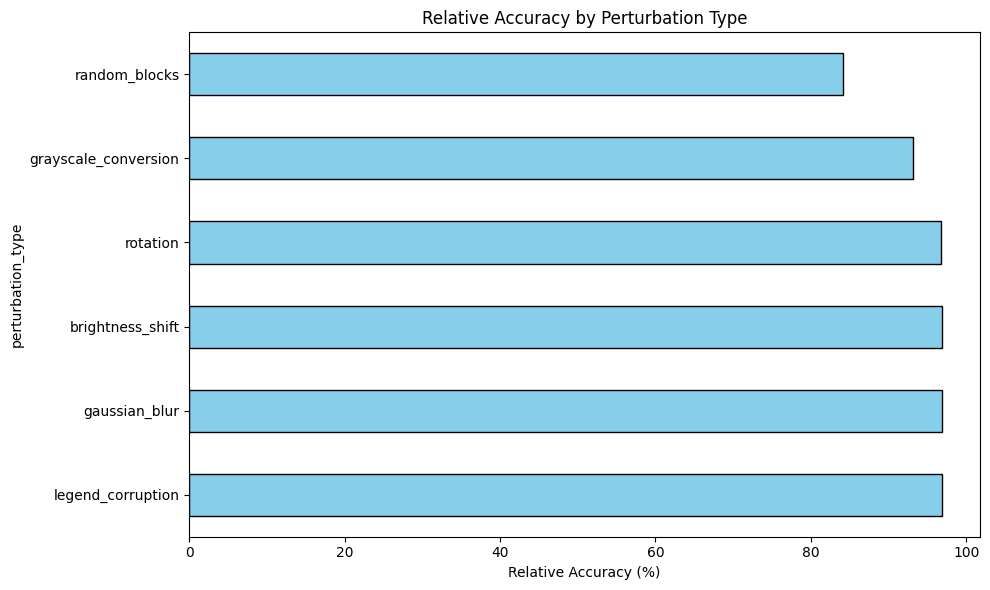


 Analysis complete with fixed format handling!


In [14]:
# Prepare final dataframe
final_columns = [
    'extraction_key', 'chart_id', 'is_original', 'perturbation_type',
    'exact_match_accuracy', 'f1_score', 'value_accuracy', 'chart_type_accuracy',
    'relative_accuracy', 'extraction_confidence'
]

# Ensure relative_accuracy column exists
if 'relative_accuracy' not in df_results.columns:
    df_results['relative_accuracy'] = 0.0

df_final = df_results[final_columns].copy()

# Save results
output_file = RESULTS_PATH / f"relative_accuracy_analysis_FIXED_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_final.to_csv(output_file, index=False)
print(f"\n Results saved to: {output_file.name}")

# Create visualizations
plt.figure(figsize=(10, 6))
if len(ra_by_type) > 0:
    ra_by_type['mean'].plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel('Relative Accuracy (%)')
    plt.title('Relative Accuracy by Perturbation Type')
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'ra_by_perturbation_FIXED.png', dpi=300)
    plt.show()

print("\n Analysis complete with fixed format handling!")

### removed the exact match which does made any sense add composite score

In [17]:
import pandas as pd

# Load the original results CSV
df = pd.read_csv("E:/langchain/Dissertation/results/relative_accuracy_analysis_FIXED_20250730_160513.csv")

# Step 1: Calculate Composite Score (excluding chart_type_accuracy)
df['composite_score'] = (
    df['f1_score'] +
    (df['value_accuracy'] / 100)
) / 2 * 100  # scale to 0–100

# Step 2: Initialize new RA column
df['relative_accuracy_updated'] = None

# Step 3: Calculate RA based on composite score
for chart_id in df['chart_id'].unique():
    if chart_id == 'failed':
        continue

    original = df[(df['chart_id'] == chart_id) & (df['is_original'] == True)]
    if original.empty:
        continue

    original_score = original['composite_score'].iloc[0]

    mask = (df['chart_id'] == chart_id) & (df['is_original'] == False)
    if original_score > 0:
        df.loc[mask, 'relative_accuracy_updated'] = (
            df.loc[mask, 'composite_score'] / original_score * 100
        ).clip(upper=100)
    else:
        df.loc[mask, 'relative_accuracy_updated'] = 0.0

# Step 4: Set RA for originals and failed
df.loc[df['is_original'] == True, 'relative_accuracy_updated'] = 100.0
df.loc[df['perturbation_type'] == 'failed', 'relative_accuracy_updated'] = 0.0

# Step 5: Export to a new CSV
df.to_csv("relative_accuracy_updated_FINAL.csv", index=False)
print(" Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)")


 Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)


## 📊 Relative Accuracy Recalculation (F1 + Value Accuracy Only)

This code recalculates the **composite score** and **relative accuracy** (`RA`) using only:

- `f1_score` — Structural/partial match quality
- `value_accuracy` — Numerical correctness (within 10% tolerance)

> 🎯 Note: `chart_type_accuracy` and `exact_match_accuracy` are retained in the CSV for reference, but **not used in any metric calculation**.

---

### 🧮 Composite Score Formula

The `composite_score` is calculated as the average of:

\[
\text{composite\_score} = \left( \text{f1\_score} + \frac{\text{value\_accuracy}}{100} \right) \div 2 \times 100
\]

This gives a **0–100 scaled score** combining both structural and value fidelity.

---

### 🔁 Relative Accuracy (RA) Formula

RA compares the performance of a **perturbed chart** to its corresponding **original chart**:

\[
\text{RA}_{\text{perturbed}} = \left( \frac{\text{composite}_{\text{perturbed}}}{\text{composite}_{\text{original}}} \right) \times 100
\]

- Originals are assigned `RA = 100`
- Perturbations are capped at `100` to avoid inflation
- Failed extractions are assigned `RA = 0`

---

### ✅ Final Code (Safe to Run at End of Pipeline)

```python
import pandas as pd

# Load original results
df = pd.read_csv("relative_accuracy_analysis_FIXED_20250730_160513.csv")

# Composite score: only F1 + value accuracy
df['composite_score'] = (
    df['f1_score'] +
    (df['value_accuracy'] / 100)
) / 2 * 100

# Initialize updated RA column
df['relative_accuracy_updated'] = None

# Calculate RA for each chart group
for chart_id in df['chart_id'].unique():
    if chart_id == 'failed':
        continue

    original = df[(df['chart_id'] == chart_id) & (df['is_original'] == True)]
    if original.empty:
        continue

    original_score = original['composite_score'].iloc[0]

    mask = (df['chart_id'] == chart_id) & (df['is_original'] == False)
    if original_score > 0:
        df.loc[mask, 'relative_accuracy_updated'] = (
            df.loc[mask, 'composite_score'] / original_score * 100
        ).clip(upper=100)
    else:
        df.loc[mask, 'relative_accuracy_updated'] = 0.0

# Set fixed RA values for clean/fail cases
df.loc[df['is_original'] == True, 'relative_accuracy_updated'] = 100.0
df.loc[df['perturbation_type'] == 'failed', 'relative_accuracy_updated'] = 0.0

# Save new version
df.to_csv("relative_accuracy_updated_FINAL.csv", index=False)
print("✅ Exported to relative_accuracy_updated_FINAL.csv (f1 + value only)")


# 📈 Metric Descriptions for Chart Extraction Robustness Evaluation

This document explains the key metrics used to assess GPT-4's performance on extracting data from charts, especially under visual perturbations.

---

## 1. F1 Score (`f1_score`)
**What it measures:**  
How well the extracted category–value pairs match the ground truth.

- Allows partial matches
- Captures structural alignment of extracted data
- Tolerant to small differences in category formatting

**Range:** 0 (no match) to 1 (perfect match)  
**Why it matters:** Shows how well GPT-4 understands the structure of the chart.

---

## 2. Value Accuracy (`value_accuracy`)
**What it measures:**  
The percentage of numeric values that match the ground truth within a 10% tolerance.

- Ignores categories; focuses only on values
- Tolerates small numerical variations

**Range:** 0% to 100%  
**Why it matters:** Checks whether GPT-4 accurately reads the data, even if labels are imperfect.

---

## 3. Composite Score (`composite_score`)
**What it measures:**  
The average of F1 score and value accuracy (scaled to 0–100):

- composite_score = (f1_score + (value_accuracy / 100)) / 2 × 100

**Why it matters:** Provides a single score summarizing overall extraction quality.

---

## 4. Relative Accuracy (`relative_accuracy_updated`)
**What it measures:**  
How much performance drops when a chart is perturbed compared to its original version.

- RA = (composite_score of perturbed / composite_score of original) × 100
- Original (clean) charts always have RA = 100
- Perturbed charts have RA ≤ 100
- Failed extractions are assigned RA = 0

**Why it matters:** Quantifies the model’s robustness to visual distortion.

---

## Additional Metrics (Reported but Not Used in RA Calculation)

### ✔ Chart Type Accuracy (`chart_type_accuracy`)
- Measures whether GPT-4 correctly identifies the type of chart (bar, line, pie, etc.)
- Always included in the CSV
- Not used in composite or RA since it's always 100%

### ❌ Exact Match Accuracy (`exact_match_accuracy`)
- Checks for a perfect match between all data points and labels
- Too strict for practical use (often 0%)
- Kept for completeness but excluded from scoring

---

## ✅ Summary of Metric Use

| Metric               | Used in Composite? | Used in RA? | Kept in CSV? |
|----------------------|--------------------|-------------|---------------|
| F1 Score             | ✅                 | ✅          | ✅             |
| Value Accuracy       | ✅                 | ✅          | ✅             |
| Chart Type Accuracy  | ❌                 | ❌          | ✅             |
| Exact Match Accuracy | ❌                 | ❌          | ✅             |

---
